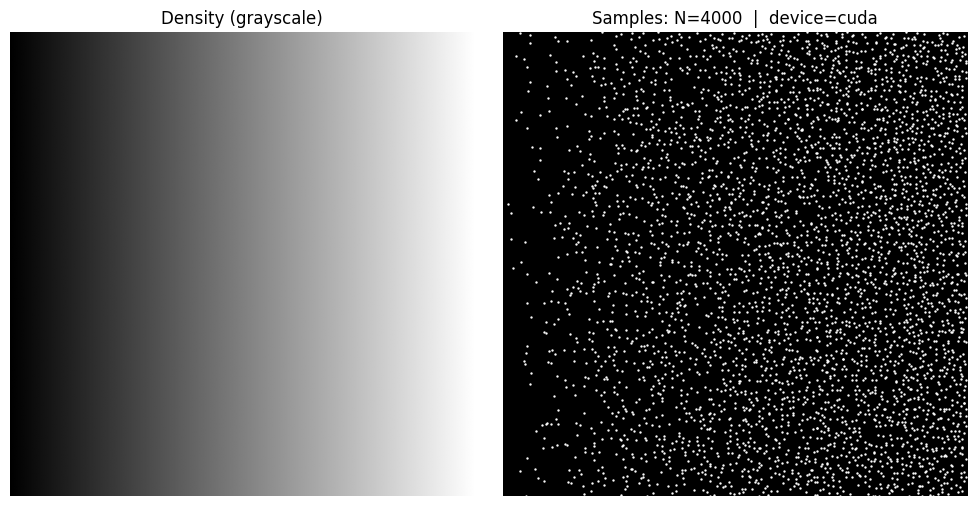

In [ ]:
# High-performance, GPU-parallel, density-controlled blue-noise sampling
# =============================================================================
# Academic-quality, readable, single-cell implementation for Colab/PyTorch.
#
# Key ideas
# ---------
# • You provide ANY density as a Python lambda:  rho(u, v) on [0,1]×[0,1].
# • We generate a quasi-blue-noise *uniform* set via stratified jittered grid (fully vectorized).
# • We then **select** a subset of points *according to your density* using the Gumbel-Top-K trick
#   (parallel, without replacement), which preserves good spacing from the stratified pool.
# • No O(N^2) loops, no per-point neighbor scans. Everything is batched and GPU-friendly.
#
# What you get
# ------------
# • `sample_blue_noise_density(...)` returns integer pixel coords (n_points×2) aligned to `res×res`.
# • Side-by-side plot: grayscale ramp image (your density) and the sampled points.
#
# Notes
# -----
# • For “ramp” densities (linear, vertical, radial, etc.), just pass a lambda. Examples below.
# • If later you require stricter minimal-distance enforcement, add a single grid-based culling pass;
#   the current method already provides very good spacing for training data due to stratification.

import math
import torch
import matplotlib.pyplot as plt

# ---------------------------
# Utilities & core primitives
# ---------------------------

def _pick_device(device: str | None = None) -> str:
    """Pick CUDA if available unless explicitly requested otherwise."""
    if device is not None:
        return device
    return "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def _make_jittered_grid(n_points: int, oversample: float, device: str) -> torch.Tensor:
    """
    Stratified jittered grid in [0,1]^2.
    Generates M = ceil(n_points * oversample) points, then shuffles.

    Returns: (M, 2) tensor on `device`, coordinates in [0,1].
    """
    M = int(math.ceil(n_points * max(1.0, oversample)))
    G = int(math.ceil(math.sqrt(M)))             # grid resolution
    ix = torch.arange(G, device=device, dtype=torch.float32)
    iy = torch.arange(G, device=device, dtype=torch.float32)
    X, Y = torch.meshgrid(ix, iy, indexing="xy") # (G,G)

    # Stratified: one random jitter per cell
    jitter = torch.rand((G, G, 2), device=device)
    pts = (torch.stack([X, Y], dim=-1) + jitter) / G   # (G,G,2) → in [0,1]
    pts = pts.view(-1, 2)                               # (G*G, 2)

    # Random shuffle and truncate to M
    idx = torch.randperm(pts.shape[0], device=device)[:M]
    return pts[idx]

@torch.no_grad()
def _eval_density_on_grid(res: int, density_fn, device: str) -> torch.Tensor:
    """
    Evaluate a user-supplied density function ρ(u,v) over a res×res grid on [0,1]^2.

    density_fn must accept tensors U,V (broadcastable) and return nonnegative values.
    Returns: ρ as (res,res) tensor on `device`, normalized to sum=1 (with epsilon for safety).
    """
    # Grid of normalized coordinates
    xs = torch.linspace(0.0, 1.0, res, device=device)
    ys = torch.linspace(0.0, 1.0, res, device=device)
    U, V = torch.meshgrid(xs, ys, indexing="xy")

    rho = density_fn(U, V)
    rho = torch.clamp(rho, min=0.0)
    s = rho.sum()
    rho = rho / (s + 1e-12)
    return rho

@torch.no_grad()
def _eval_density_on_points(pts_uv: torch.Tensor, density_fn) -> torch.Tensor:
    """
    Evaluate ρ(u,v) for a (N,2) tensor of points in [0,1]^2.

    Returns: (N,) nonnegative, normalized weights (sum=1).
    """
    u, v = pts_uv[:, 0], pts_uv[:, 1]
    w = density_fn(u, v)
    w = torch.clamp(w, min=0.0)
    w_sum = w.sum()
    w = w / (w_sum + 1e-12)
    return w

@torch.no_grad()
def _gumbel_topk_sample_without_replacement(weights: torch.Tensor, k: int) -> torch.Tensor:
    """
    Parallel sampling w/out replacement using Gumbel-Top-K.
    We sample top-k indices according to 'weights' (already nonnegative, not all zero).

    Returns: (k,) indices (dtype long).
    """
    # logw + Gumbel noise → top-k
    logw = torch.log(weights + 1e-20)
    g = -torch.log(-torch.log(torch.rand_like(logw) + 1e-20) + 1e-20)
    scores = logw + g
    return torch.topk(scores, k=k, largest=True).indices

# ---------------------------
# Main public API
# ---------------------------

@torch.no_grad()
def sample_blue_noise_density(
    res: int = 512,
    n_points: int = 3000,
    density_fn = None,            # required: lambda U,V → ρ(U,V) on [0,1]^2
    oversample: float = 2.0,       # >1 gives a richer stratified pool to select from
    device: str | None = None,
    seed: int | None = None,
    plot: bool = True
):
    """
    High-performance, GPU-parallel sampling of n_points distributed according to ρ(u,v),
    while preserving good spacing via stratified jittered grid + Gumbel-Top-K selection.

    Parameters
    ----------
    res : int
        Output resolution (res×res). Used for ramp image and for final integer coordinates.
    n_points : int
        Number of points to return.
    density_fn : callable
        User-provided lambda ρ(U,V) mapping [0,1]^2 → nonnegative densities (tensor-friendly).
        Must support torch tensors, e.g.:
            rho_linear_x = lambda U,V: U
            rho_vertical = lambda U,V: V**2
            rho_radial   = lambda U,V: (1.0 - torch.sqrt((U-0.5)**2 + (V-0.5)**2)/0.7071).clamp(min=0.0)
    oversample : float
        Factor for stratified pool size (M ≈ n_points * oversample). Higher → better spacing fidelity.
    device : str | None
        "cuda" or "cpu"; if None, auto-selects CUDA if available.
    seed : int | None
        RNG seed for reproducibility.
    plot : bool
        If True, render side-by-side: density (grayscale) and sampled points.

    Returns
    -------
    coords : torch.IntTensor (n_points, 2) on CPU
        Integer pixel coordinates (x,y) in [0, res-1].
    """
    assert callable(density_fn), "Please provide a density_fn: lambda U,V → rho(U,V)."

    device = _pick_device(device)
    if seed is not None:
        torch.manual_seed(seed)
        if device == "cuda":
            torch.cuda.manual_seed_all(seed)

    # 1) Evaluate the density on a grid (for visualization) and normalize.
    rho_grid = _eval_density_on_grid(res, density_fn, device=device)  # (res,res), sum=1

    # 2) Build a stratified candidate pool (quasi-blue-noise uniform in [0,1]^2).
    pool_uv = _make_jittered_grid(n_points=n_points, oversample=oversample, device=device)  # (M,2)

    # 3) Compute normalized weights at pool samples according to the density.
    w = _eval_density_on_points(pool_uv, density_fn)  # (M,), sum=1

    # 4) Parallel sampling without replacement: pick exactly n_points by weight.
    sel_idx = _gumbel_topk_sample_without_replacement(w, k=n_points)  # (n_points,)
    pts_uv = pool_uv[sel_idx]  # (n_points,2) in [0,1]

    # 5) Convert to integer pixel coordinates in [0,res-1].
    coords = (pts_uv * res).clamp(0, res - 1 - 1e-6).floor().to(torch.int32).to("cpu")  # (n_points,2)

    # 6) Optional side-by-side plot: grayscale density + sampled points
    if plot:
        # Density image (grayscale)
        rho_img = rho_grid.detach().cpu()
        rho_img = (rho_img / (rho_img.max() + 1e-12)).float()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Left: density function
        axes[0].imshow(rho_img.numpy(), cmap="gray", origin="upper", vmin=0.0, vmax=1.0)
        axes[0].set_title("Density (grayscale)")
        axes[0].axis("off")

        # Right: sampled points (scatter)
        axes[1].imshow(torch.ones((res, res)), cmap="gray", origin="upper")
        axes[1].scatter(coords[:,0], coords[:,1], s=2, c="white", marker=".")
        axes[1].set_title(f"Samples: N={n_points}  |  device={device}")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()


    return coords

# ---------------------------------
# Example usage (edit/replace below)
# ---------------------------------
if __name__ == "__main__":
    # EXAMPLE 1: Linear ramp (left→right denser)
    rho_linear_x = lambda U, V: U

    # EXAMPLE 2: Vertical quadratic ramp (top→bottom, stronger at bottom)
    rho_vertical_quad = lambda U, V: V**2

    # EXAMPLE 3: Radial center-dense (smooth, zero at corners, one near center)
    # 0.7071 ≈ max distance from center to a square corner in unit square (sqrt(2)/2)
    rho_radial = lambda U, V: (1.0 - torch.sqrt((U-0.5)**2 + (V-0.5)**2) / 0.7071).clamp(min=0.0)

    _ = sample_blue_noise_density(
        res=512,
        n_points=4000,
        density_fn=rho_linear_x,   # swap in any lambda above (or your own)
        # density_fn=rho_radial,   # swap in any lambda above (or your own)
        oversample=2.0,
        device=None,               # auto: CUDA if available
        seed=1234,
        plot=True
    )


In [ ]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def cc_lloyd_relaxation_wrapper(
    base_sampler,
    density_fn,
    res=512,
    n_points=3000,
    iters=5,
    device=None,
    seed=None,
    plot=True
):
    """
    Wraps an existing blue-noise sampler with capacity-constrained Lloyd relaxation.

    Parameters
    ----------
    base_sampler : callable
        Your existing sampler function (e.g. sample_blue_noise_density).
        Must return (n_points, 2) float/int coordinates in [0,res).
    density_fn : callable
        Density function rho(U,V) on [0,1]^2.
    res : int
        Domain resolution for both sampling and Lloyd grid.
    n_points : int
        Number of points.
    iters : int
        Number of CC Lloyd iterations.
    device : str or None
        "cuda" or "cpu"; auto-selects CUDA if available.
    seed : int or None
        RNG seed.
    plot : bool
        If True, show before/after scatter side-by-side.

    Returns
    -------
    coords_relaxed : torch.Tensor
        (n_points,2) final relaxed coordinates on CPU.
    """
    device = "cuda" if (device is None and torch.cuda.is_available()) else "cpu"
    if seed is not None:
        torch.manual_seed(seed)
        if device == "cuda":
            torch.cuda.manual_seed_all(seed)

    # 1. Generate initial samples with base sampler
    coords0 = base_sampler(res=res, n_points=n_points,
                           density_fn=density_fn, device=device,
                           seed=seed, plot=False).float().to(device)

    coords = coords0.clone()

    # 2. Build discrete grid for CC Lloyd iterations
    xs = torch.linspace(0, 1, res, device=device)
    ys = torch.linspace(0, 1, res, device=device)
    U, V = torch.meshgrid(xs, ys, indexing="xy")
    rho = density_fn(U, V).clamp(min=0.0)
    rho = rho / (rho.sum() + 1e-12)  # normalize weights
    rho = rho.unsqueeze(-1)  # (res,res,1)

    grid = torch.stack([U*res, V*res], dim=-1)  # (res,res,2) pixel centers

    # 3. CC Lloyd iterations
    for _ in range(iters):
        # Compute nearest site for each pixel
        d2 = torch.cdist(grid.view(-1,2), coords)  # (res*res, n_points)
        assign = d2.argmin(dim=1)                  # nearest site index per pixel

        # Weighted centroids
        rho_flat = rho.view(-1)                    # weights per pixel
        num = torch.zeros((n_points,2), device=device)
        den = torch.zeros((n_points,), device=device)

        num.index_add_(0, assign, grid.view(-1,2) * rho_flat[:,None])
        den.index_add_(0, assign, rho_flat)

        coords = num / (den[:,None] + 1e-12)

    # rescale to 512×512 output
    coords_relaxed = torch.zeros((n_points, 2), device=device)
    if res != 512:
        # coords_relaxed = torch.zeros((n_points, 2), device=device)
        coords_relaxed = (coords_relaxed / res * 512).clamp(0, 511).to(torch.int32)

    coords_relaxed = coords.to("cpu")

    # 4. Plot before vs after
    if plot:
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].scatter(coords0[:,0].cpu(), coords0[:,1].cpu(),
                        s=2, c="black")
        axes[0].set_title("Initial samples")
        axes[0].set_xlim(0,res); axes[0].set_ylim(res,0); axes[0].axis("off")

        axes[1].scatter(coords_relaxed[:,0], coords_relaxed[:,1],
                        s=2, c="black")
        axes[1].set_title(f"CC Lloyd-relaxed ({iters} iters)")
        axes[1].set_xlim(0,res); axes[1].set_ylim(res,0); axes[1].axis("off")
        plt.tight_layout(); plt.show()

    return coords_relaxed


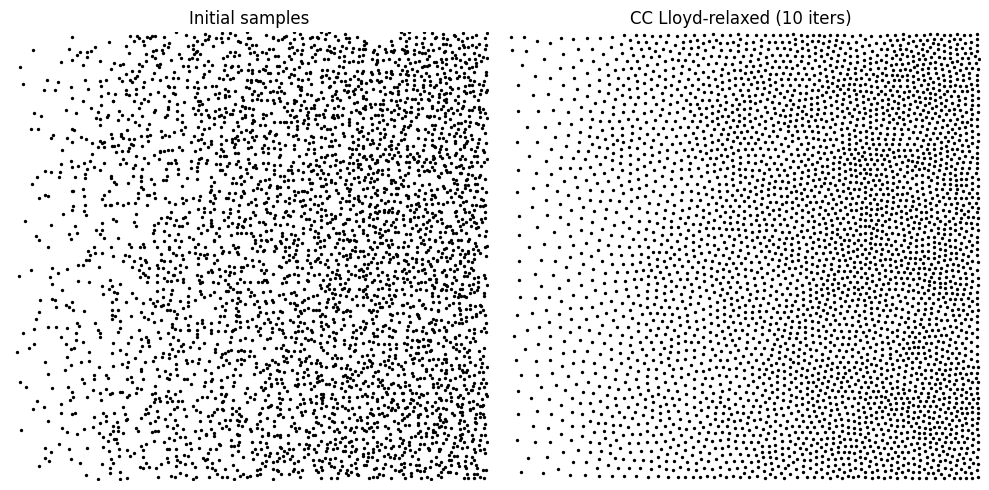

Final relaxed coords shape: torch.Size([4000, 2])


In [ ]:
# Example usage of CC Lloyd wrapper
if __name__ == "__main__":
    # Define a ramp density function (example: linear ramp left→right)
    rho_linear = lambda U, V: U

    # Run the wrapper
    coords_relaxed = cc_lloyd_relaxation_wrapper(
        base_sampler=sample_blue_noise_density,  # your existing sampler
        density_fn=rho_linear,
        res=512,          # domain resolution (keep lower for speed in Lloyd)
        n_points=4000,    # number of points
        iters=10,          # CC Lloyd iterations
        device=None,      # auto: CUDA if available
        seed=12345,
        plot=True         # show before/after
    )

    print("Final relaxed coords shape:", coords_relaxed.shape)


In [ ]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def cc_lloyd_multires_wrapper(
    base_sampler,
    density_fn,
    n_points=3000,
    out_res=512,
    iters_per_level=(2,1),  # (coarse_iters, fine_iters)
    levels=(128, 512),      # grid resolutions to use progressively
    device=None,
    seed=None,
    plot=True
):
    """
    Multi-resolution capacity-constrained Lloyd relaxation (discretized).
    Starts from base_sampler, refines sites on coarse then fine grids.

    Parameters
    ----------
    base_sampler : callable
        Your existing sampler, e.g. sample_blue_noise_density.
    density_fn : callable
        Density function rho(U,V) on [0,1]^2.
    n_points : int
        Number of points.
    out_res : int
        Output resolution (final coordinates scaled to this).
    iters_per_level : tuple(int,int)
        Number of Lloyd iterations at each level.
    levels : tuple(int,int)
        Grid resolutions (coarse → fine).
    device : str or None
        "cuda" or "cpu"; auto-selects CUDA if available.
    seed : int or None
        RNG seed.
    plot : bool
        If True, scatter before/after.

    Returns
    -------
    coords_relaxed : (n_points,2) tensor on CPU
    """
    device = "cuda" if (device is None and torch.cuda.is_available()) else "cpu"
    if seed is not None:
        torch.manual_seed(seed)
        if device == "cuda":
            torch.cuda.manual_seed_all(seed)

    # Initial points
    coords0 = base_sampler(res=out_res, n_points=n_points,
                           density_fn=density_fn, device=device,
                           seed=seed, plot=False).float().to(device)
    coords = coords0.clone()

    # Progressive Lloyd iterations
    for level_res, n_iter in zip(levels, iters_per_level):
        # Precompute density and pixel grid at this resolution
        xs = torch.linspace(0, 1, level_res, device=device)
        ys = torch.linspace(0, 1, level_res, device=device)
        U, V = torch.meshgrid(xs, ys, indexing="xy")
        rho = density_fn(U, V).clamp(min=0.0)
        rho = rho / (rho.sum() + 1e-12)
        rho_flat = rho.view(-1)
        pixels = torch.stack([U*level_res, V*level_res], dim=-1).view(-1,2)  # (M,2)

        for _ in range(n_iter):
            # Assign pixels to nearest site
            d2 = torch.cdist(pixels, coords)     # (M,n_points)
            assign = d2.argmin(dim=1)            # nearest site idx

            # Weighted centroids
            num = torch.zeros((n_points,2), device=device)
            den = torch.zeros((n_points,), device=device)
            num.index_add_(0, assign, pixels * rho_flat[:,None])
            den.index_add_(0, assign, rho_flat)
            coords = num / (den[:,None] + 1e-12)

    # Scale to output resolution
    coords_relaxed = (coords / levels[-1] * out_res).clamp(0, out_res-1).to("cpu")

    if plot:
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].scatter(coords0[:,0].cpu(), coords0[:,1].cpu(), s=2, c="black")
        axes[0].set_title("Initial samples")
        axes[0].set_xlim(0,out_res); axes[0].set_ylim(out_res,0); axes[0].axis("off")
        axes[1].scatter(coords_relaxed[:,0], coords_relaxed[:,1], s=2, c="black")
        axes[1].set_title(f"CC Lloyd relaxed ({iters_per_level} iters)")
        axes[1].set_xlim(0,out_res); axes[1].set_ylim(out_res,0); axes[1].axis("off")
        plt.tight_layout(); plt.show()

    return coords_relaxed


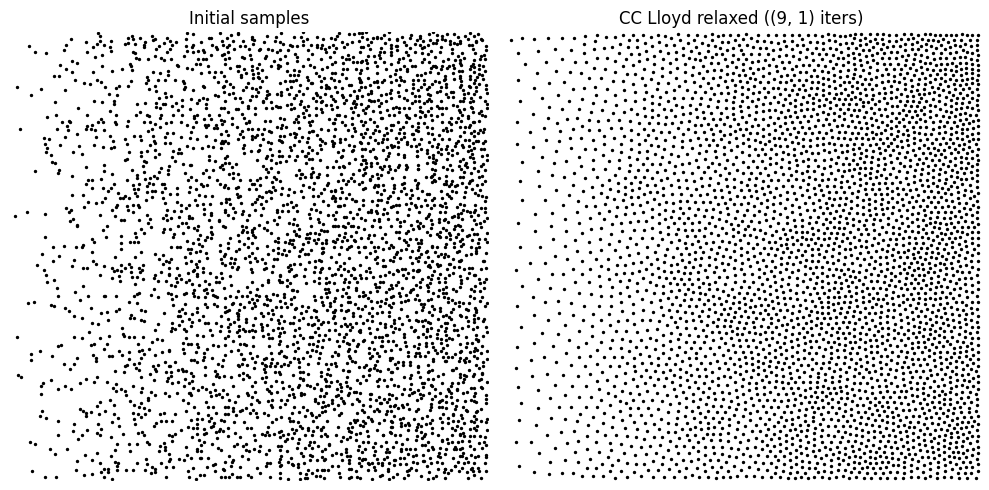

Final relaxed coords shape: torch.Size([4000, 2])


In [ ]:
# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    # Example density: linear ramp left→right
    rho_linear = lambda U, V: U

    # Run the multi-resolution CC Lloyd wrapper
    coords_relaxed = cc_lloyd_multires_wrapper(
        base_sampler=sample_blue_noise_density,  # <- your existing sampler
        density_fn=rho_linear,
        n_points=4000,
        out_res=512,
        iters_per_level=(9, 1),  # 2 iterations on coarse grid, 1 on fine grid
        levels=(512, 512),       # first 128² grid, then refine at 512²
        device=None,             # auto-select CUDA if available
        seed=42,
        plot=True                # show before/after scatter
    )

    print("Final relaxed coords shape:", coords_relaxed.shape)


In [ ]:
print(coords_relaxed)


tensor([[292.2705, 128.4370],
        [394.8911, 148.5947],
        [167.4204,  11.5883],
        ...,
        [ 68.4817, 147.2579],
        [188.3584, 351.1216],
        [502.9678, 240.9703]])


# **Power-spectrum analysis of a 2-D point set (blue-noise diagnosis)**

Let a set of $N$ points $\{x_n\}_{n=1}^N \subset [0,1)^2$ be rasterized on an $M\times M$ periodic grid (toroidal boundary).  
Define the **occupancy image**

$$
I(\mathbf{m}) \triangleq \sum_{n=1}^N \delta_{\mathbf{m},\,\lfloor M x_n\rfloor},
\qquad \mathbf{m}=(m_1,m_2)\in\{0,\ldots,M-1\}^2,
$$

where $\delta$ is the Kronecker delta.  
Equivalently, if each point is splatted by a pixel (or a small Gaussian), $I$ is the resulting discrete image.

---

### 1. **DC removal (mean subtraction)**

Let the mean intensity be  

$$
\mu \triangleq \frac{1}{M^2}\sum_{\mathbf{m}} I(\mathbf{m}) = \frac{N}{M^2}.
$$

Define the zero-mean field  

$$
J(\mathbf{m}) \triangleq I(\mathbf{m}) - \mu .
$$

This eliminates the **DC component** so that low-frequency power is not dominated by the non-zero mean.

---

### 2. **Discrete Fourier Transform (DFT)**

For frequency index $\mathbf{k}=(k_1,k_2)\in\{0,\ldots,M-1\}^2$, the 2-D DFT is  

$$
\widehat{J}(\mathbf{k}) = \sum_{\mathbf{m}} J(\mathbf{m})
\exp\!\Big(-2\pi i\,\frac{\mathbf{k}\cdot\mathbf{m}}{M}\Big),
\qquad
\mathbf{k}\cdot\mathbf{m}=k_1 m_1+k_2 m_2 .
$$

(With `fftshift`, we visualize $\widehat{J}$ with the zero frequency centered.)

---

### 3. **Power Spectral Density (PSD)**

The **periodogram** (finite-sample PSD estimate) is  

$$
P(\mathbf{k}) \triangleq \big|\widehat{J}(\mathbf{k})\big|^2 .
$$

We typically ignore the $\mathbf{k}=0$ bin (DC) since $J$ is mean-zero.

---

### 4. **Radial averaging**

To summarize isotropic content we average $P(\mathbf{k})$ over circular shells in frequency space.  
Let  

$$
|\mathbf{k}| = \sqrt{(k_1-M/2)^2+(k_2-M/2)^2},
$$

after centering.  
For integer radii $r=0,1,\ldots$, define the **radially averaged spectrum**

$$
\overline{P}(r) \triangleq
\frac{1}{|\mathcal{B}_r|}
\sum_{\mathbf{k}:\; r \le |\mathbf{k}| < r+1 } P(\mathbf{k}),
$$

where $\mathcal{B}_r$ is the set of frequency samples in the $r$-th annulus.  
We often report the normalized profile $\overline{P}(r)/\max_r \overline{P}(r)$ and plot $\log(1+P)$ for the 2-D image to enlarge dynamic range.

---

## **What the plots show**

* **2-D log-power image $\log(1+P(\mathbf{k}))$**  
  A **blue-noise** pattern exhibits a **central low-power hole** (suppression at small $|\mathbf{k}|$, i.e., low spatial frequencies) and an **annular ridge** at mid frequencies.  
  The ridge radius $k_0$ corresponds to the characteristic inter-point spacing: for number density $\lambda=N$ (per unit area) one expects $k_0 = \Theta(\sqrt{\lambda})$ (the ring occurs near the reciprocal of the typical spacing).

* **Radially averaged profile $\overline{P}(r)$**  
  For blue noise, $\overline{P}(r)$ is **near zero at low $r$** (blue hole), **peaks around $r \approx k_0$** (dominant spacing scale), and then becomes **approximately flat** toward higher $r$ (decorrelated high-frequency content).

  In contrast:
  - **Poisson (white) noise:** $\overline{P}(r)$ is flat for all $r$ (no low-frequency suppression, no ring).  
  - **Periodic lattices:** sharp **Bragg peaks** at specific $\mathbf{k}$ (high anisotropy and discrete spikes).

---

## **Notes on estimation and interpretation**

* **Periodicity / torus.** Rasterizi*


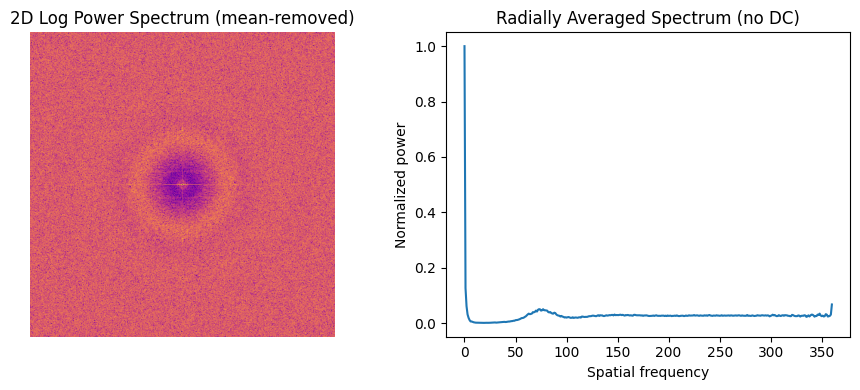

In [ ]:
# --- Blue-noise spectrum (DC-removed, clean radial profile) ---
import torch
import matplotlib.pyplot as plt

# pts -> integer pixel coords (N,2)
pts = coords_relaxed if 'coords_relaxed' in globals() else coords
pts = pts.to('cpu').to(torch.int64)
res = int(torch.max(pts).item()) + 1

img = torch.zeros((res, res), dtype=torch.float32)
img[pts[:,1].clamp(0, res-1), pts[:,0].clamp(0, res-1)] = 1.0

# REMOVE DC: subtract mean so total mass is zero
img = img - img.mean()

F = torch.fft.fftshift(torch.fft.fft2(img))
P = (F.real**2 + F.imag**2)

# radial average (skip r=0 to avoid DC bin)
yy, xx = torch.meshgrid(torch.arange(res), torch.arange(res), indexing="ij")
rr = torch.sqrt((xx - res/2.0)**2 + (yy - res/2.0)**2).to(torch.int64)
tbin = torch.bincount(rr.view(-1), weights=P.view(-1))
nbin = torch.bincount(rr.view(-1))
radial = tbin / torch.clamp(nbin, min=1)
radial = radial[1:]  # drop DC bin

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].imshow(torch.log1p(P.clamp_min(0)).numpy(), cmap="plasma", origin="upper")
ax[0].set_title("2D Log Power Spectrum (mean-removed)")
ax[0].axis("off")
ax[1].plot((radial / radial.max()).numpy())
ax[1].set_title("Radially Averaged Spectrum (no DC)")
ax[1].set_xlabel("Spatial frequency")
ax[1].set_ylabel("Normalized power")
plt.tight_layout()
plt.show()


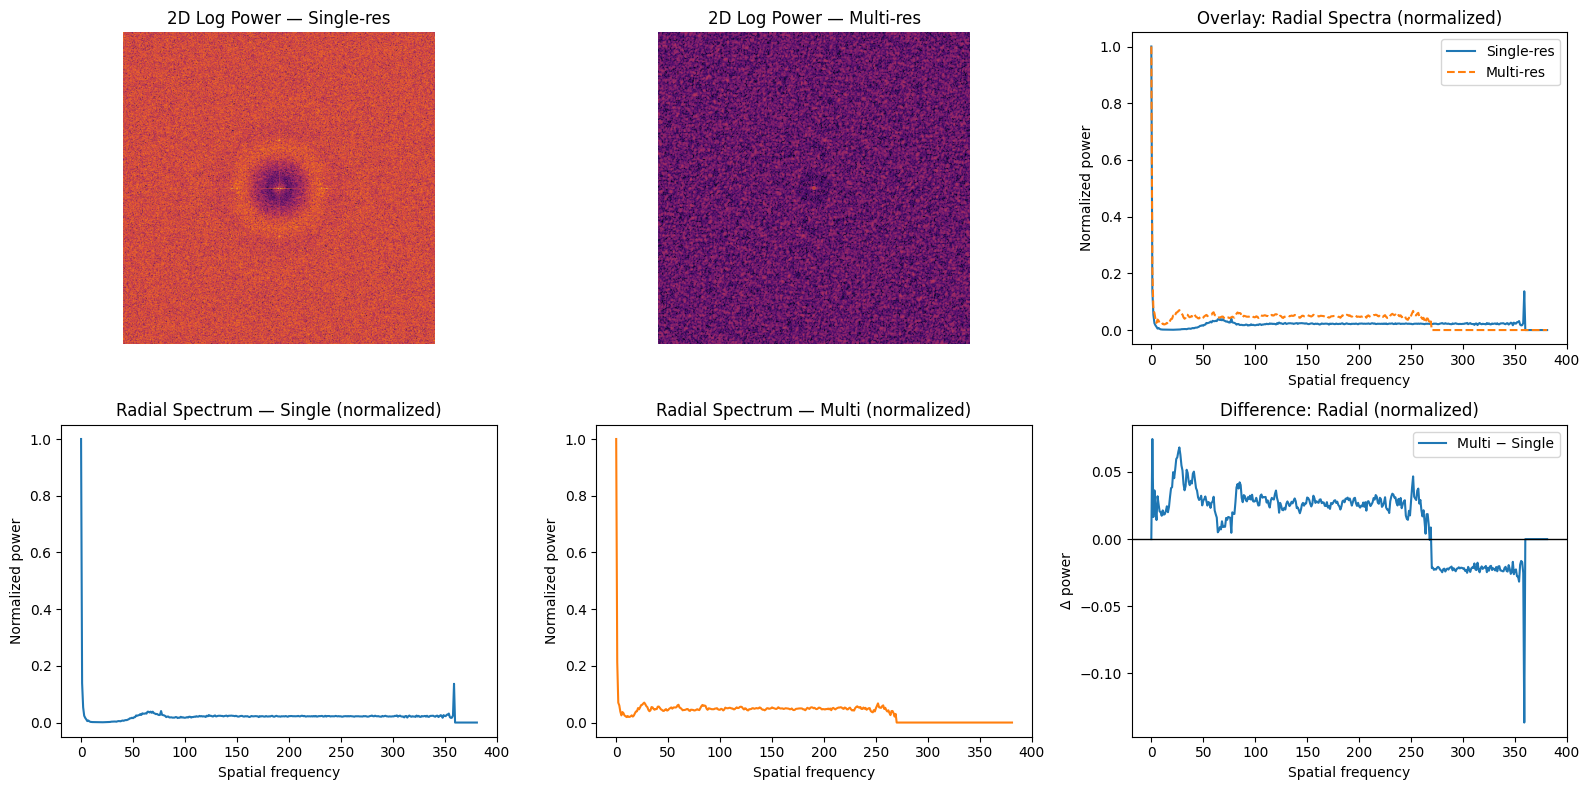

In [ ]:
# ================================================================
# Clean, working comparison using the two generators (3-column view)
# - Defines ONE function: spectrum_from_coords()
# - Calls cc_lloyd_relaxation_wrapper and cc_lloyd_multires_wrapper
#   with the correct signatures from your notebook
# - Uses a density function defined below (or your existing one if present)
# - Plots a 2x3 figure: [Single method | Multi method | Overlay & Difference]
# ================================================================

import torch
import matplotlib.pyplot as plt

# --------- 1) Spectrum calculation (single function, as requested) ----------
def spectrum_from_coords(coords: torch.Tensor):
    """
    Compute 2D log-power spectrum and radial average from integer pixel coords.
    coords: (N,2) int tensor with values in [0, R-1] for some resolution R.
    Returns:
        Plog  : (R,R) float tensor = log(1 + power), CPU
        radial: (<=R) float tensor = radially averaged power (DC removed), CPU
    """
    if not isinstance(coords, torch.Tensor):
        raise TypeError("coords must be a torch.Tensor")
    if coords.ndim != 2 or coords.shape[1] != 2:
        raise ValueError("coords must have shape (N, 2)")

    pts = coords.detach().to('cpu', dtype=torch.int64)
    R = int(torch.max(pts).item()) + 1
    if R <= 1:
        raise ValueError("Invalid resolution inferred from coords.")

    img = torch.zeros((R, R), dtype=torch.float32)
    img[pts[:, 1].clamp(0, R-1), pts[:, 0].clamp(0, R-1)] = 1.0

    # Remove DC so low-f power isn’t dominated by the mean occupancy
    img = img - img.mean()

    # 2D FFT → power
    F = torch.fft.fftshift(torch.fft.fft2(img))
    P = (F.real**2 + F.imag**2)

    # Radial average (integer annuli), drop DC bin
    yy, xx = torch.meshgrid(torch.arange(R), torch.arange(R), indexing="ij")
    rr = torch.sqrt((xx - R/2.0)**2 + (yy - R/2.0)**2).to(torch.int64)
    tbin = torch.bincount(rr.reshape(-1), weights=P.reshape(-1), minlength=R)
    nbin = torch.bincount(rr.reshape(-1), minlength=R)
    radial = tbin / torch.clamp(nbin, min=1)
    radial = radial[1:]  # remove DC radius

    Plog = torch.log1p(P).cpu()
    return Plog, radial.cpu()


# --------- 2) Use YOUR generators with correct signatures ----------
# Base sampler from your notebook
if 'sample_blue_noise_density' not in globals():
    raise RuntimeError("Missing `sample_blue_noise_density`. Run its defining cell first.")
base_sampler = sample_blue_noise_density

# Density function: use your existing one if available; else define a simple ramp
if 'density_fn' in globals():
    density = density_fn
elif 'rho_linear_x' in globals():
    density = rho_linear_x
elif 'rho_radial' in globals():
    density = rho_radial
else:
    # fallback: linear ramp left→right on [0,1]^2
    density = lambda U, V: U

# Parameters consistent with your wrappers’ signatures
res_single = 512
n_points   = 3000
iters_cc   = 5
device     = None
seed       = 42

# Single-resolution CC-Lloyd (correct signature)
coords_single = cc_lloyd_relaxation_wrapper(
    base_sampler=base_sampler,
    density_fn=density,
    res=res_single,
    n_points=n_points,
    iters=iters_cc,
    device=device,
    seed=seed,
    plot=False
)

# Multi-resolution CC-Lloyd (correct signature)
coords_multi = cc_lloyd_multires_wrapper(
    base_sampler=base_sampler,
    density_fn=density,
    n_points=n_points,
    out_res=512,
    iters_per_level=(2, 1),   # coarse, fine
    levels=(128, 512),
    device=device,
    seed=seed,
    plot=False
)

# --------- 3) Compute spectra using the ONE function and compare ----------
Plog_single, radial_single = spectrum_from_coords(coords_single)
Plog_multi,  radial_multi  = spectrum_from_coords(coords_multi)

# Align for comparison and normalize per-curve
L = min(len(radial_single), len(radial_multi))
rs = radial_single[:L]
rm = radial_multi[:L]
rs_n = rs / rs.max().clamp_min(1e-12)
rm_n = rm / rm.max().clamp_min(1e-12)

diff = (rm_n - rs_n)

# --------- 4) Plot in THREE COLUMNS (2 rows):
# Col 1: Single method — (top) 2D log power, (bottom) its radial
# Col 2: Multi method  — (top) 2D log power, (bottom) its radial
# Col 3: (top) overlay of normalized radials, (bottom) difference (Multi − Single)
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

# normalize both to the single range for visual comparision
vmin = min(Plog_single.min().item(), Plog_multi.min().item())
vmax = max(Plog_single.max().item(), Plog_multi.max().item())

# Column 1: Single-res
# ax[0, 0].imshow(Plog_single.numpy(), cmap="inferno", origin="upper")
ax[0, 0].imshow(Plog_single.numpy(), cmap="inferno", origin="upper", vmin=vmin, vmax=vmax)

ax[0, 0].set_title("2D Log Power — Single-res")
ax[0, 0].axis("off")
ax[1, 0].plot(rs_n.numpy())
ax[1, 0].set_title("Radial Spectrum — Single (normalized)")
ax[1, 0].set_xlabel("Spatial frequency")
ax[1, 0].set_ylabel("Normalized power")

# Column 2: Multi-res
# ax[0, 1].imshow(Plog_multi.numpy(), cmap="inferno", origin="upper")
ax[0, 1].imshow(Plog_multi.numpy(), cmap="inferno", origin="upper", vmin=vmin, vmax=vmax)
ax[0, 1].set_title("2D Log Power — Multi-res")
ax[0, 1].axis("off")
ax[1, 1].plot(rm_n.numpy(), color="tab:orange")
ax[1, 1].set_title("Radial Spectrum — Multi (normalized)")
ax[1, 1].set_xlabel("Spatial frequency")
ax[1, 1].set_ylabel("Normalized power")

# Column 3: Overlay + Difference
ax[0, 2].plot(rs_n.numpy(), label="Single-res")
ax[0, 2].plot(rm_n.numpy(), label="Multi-res", linestyle="--")
ax[0, 2].set_title("Overlay: Radial Spectra (normalized)")
ax[0, 2].set_xlabel("Spatial frequency")
ax[0, 2].set_ylabel("Normalized power")
ax[0, 2].legend()

ax[1, 2].plot(diff.numpy(), label="Multi − Single")
ax[1, 2].axhline(0, color='k', linewidth=1)
ax[1, 2].set_title("Difference: Radial (normalized)")
ax[1, 2].set_xlabel("Spatial frequency")
ax[1, 2].set_ylabel("Δ power")
ax[1, 2].legend()

plt.tight_layout()
plt.show()


# Interpretation of the three‑column spectrum comparison

## What both methods show (blue‑noise hallmarks)

* **Central low‑power hole** in the 2‑D log spectrum ⇒ **suppressed low spatial frequencies**, consistent with blue noise.
* **Annular ridge** at mid frequencies ⇒ a **characteristic spacing scale** (the “ring” corresponds to the inverse of the typical inter‑point distance).
* **Radial profiles** are near zero at low (r), rise to a mid‑frequency bump, then flatten—textbook blue‑noise behavior.

## Single‑resolution (left column)

* Ring is clear and relatively **narrow**; radial profile shows a **moderate mid‑frequency peak**.
* Noticeable **high‑frequency spike** near the Nyquist end of the radial curve; this can stem from **pixel‑level splatting and discretization** (one‑pixel impulses) and/or small residual clumping/anisotropy.
* A faint **cross** in the 2‑D plot suggests slight anisotropy introduced by rasterization or iteration dynamics; typically harmless but measurable.

## Multi‑resolution (middle column)

* The annulus is **more energy‑rich across the mid band**: the normalized radial profile sits **above** the single‑res curve over most mid frequencies.
* **Lower energy near Nyquist** (tail falls earlier), i.e., **less very‑high‑frequency noise**. This usually indicates a cleaner micro‑structure with fewer pixel‑grid artifacts.
* Visual anisotropy is small; the ring looks fairly **isotropic**.

## Overlay & difference (right column)

* **Overlay (top‑right):** orange (multi‑res) > blue (single‑res) across the **mid band** → **stronger ring** / better enforced minimum distance in the multi‑res result.
* **Difference (bottom‑right, Multi − Single):**

  * **Positive** from low–mid frequencies up to roughly the start of the high band ⇒ multi‑res concentrates **more power in the desired mid‑frequency ring**.
  * **Negative** in the high‑frequency tail ⇒ multi‑res has **less Nyquist‑range energy** (fewer grid‑level artifacts / less grain).
  * The sharp negative dip at the very end is a **Nyquist bin artifact** and not meaningful for quality.

## Practical takeaway

* **Both** methods produce valid blue‑noise samples.
* **Multi‑resolution** is **slightly better** here: it **emphasizes the ring** (more uniform spacing) **and reduces very‑high‑frequency noise** (cleaner texture), which is beneficial for anti‑aliasing/dithering and importance sampling.
* The **single‑resolution** variant is good but shows a **narrower ring** and a **higher Nyquist tail**, consistent with more pixel‑level energy.

## If you want quantitative summaries (optional next steps)

* Integrate radial power over three bands (low/mid/high) and report: low‑band mean (should be minimal), mid‑band peak height & bandwidth, high‑band tail energy.
* Report **ring radius** (r_0) (peak location) and **anisotropy** via azimuthal variance on the ring (lower is better).
* Use the **normalized Poisson‑disk radius** (\alpha) and capacity error (for density‑varying cases) to complement the spectral readout.


In [ ]:
# ================================================================
# Quantitative blue-noise metrics for two methods (clean project cell)
# - Keeps ONE spectrum function from coords
# - Adds a metrics function computing band energies, ring radius, FWHM, anisotropy
# - Prints a compact comparison table for Single vs Multi
#
# EXPECTS (from earlier cells):
#   coords_single : (N,2) int tensor in [0, R-1]^2 (single-resolution method)
#   coords_multi  : (N,2) int tensor in [0, R-1]^2 (multi-resolution method)
# ================================================================

import torch
import math

# ---------- spectrum function (unchanged behavior) ----------
def spectrum_from_coords(coords: torch.Tensor):
    if not isinstance(coords, torch.Tensor):
        raise TypeError("coords must be a torch.Tensor")
    if coords.ndim != 2 or coords.shape[1] != 2:
        raise ValueError("coords must have shape (N, 2)")

    pts = coords.detach().to('cpu', dtype=torch.int64)
    R = int(torch.max(pts).item()) + 1
    if R <= 1:
        raise ValueError("Invalid resolution inferred from coords.")

    img = torch.zeros((R, R), dtype=torch.float32)
    img[pts[:, 1].clamp(0, R-1), pts[:, 0].clamp(0, R-1)] = 1.0
    img = img - img.mean()  # remove DC

    F = torch.fft.fftshift(torch.fft.fft2(img))
    P = (F.real**2 + F.imag**2)

    yy, xx = torch.meshgrid(torch.arange(R), torch.arange(R), indexing="ij")
    rr = torch.sqrt((xx - R/2.0)**2 + (yy - R/2.0)**2).to(torch.int64)
    tbin = torch.bincount(rr.reshape(-1), weights=P.reshape(-1), minlength=R)
    nbin = torch.bincount(rr.reshape(-1), minlength=R)
    radial = tbin / torch.clamp(nbin, min=1)
    radial = radial[1:]  # drop DC radius

    Plog = torch.log1p(P).cpu()
    return Plog, radial.cpu(), P.cpu()

# ---------- metrics helper ----------
def blue_noise_metrics_from_radial(P2d: torch.Tensor, radial: torch.Tensor):
    """
    Compute quantitative diagnostics from 2D power P2d and radial profile.
    Returns dict with:
      - r0_idx: ring peak index (bin)
      - r0_rel: ring radius / Nyquist (bin / (R/2))
      - fwhm_bins: full width at half max in bins
      - low_mean, mid_mean, high_mean: band means (normalized by peak)
      - trough_depth: 1 - low_mean  (normalized)
      - tail_mean: mean of last 5% bins (normalized)
      - anisotropy_cv: coefficient of variation across angles at r0 (lower better)
    """
    L = int(radial.numel())
    # normalize radial by its maximum (ring peak)
    r_norm = radial / radial.max().clamp_min(1e-12)

    # find peak (ignore first few bins)
    start = max(3, int(0.01 * L))
    r0_idx = int(torch.argmax(r_norm[start:]).item()) + start

    # bands (data-driven):
    low_end = max(4, int(0.05 * r0_idx))
    mid_lo  = max(start, int(0.7 * r0_idx))
    mid_hi  = min(L - 1, int(1.4 * r0_idx))
    high_lo = max(int(1.7 * r0_idx), int(0.7 * L))

    low_mean  = r_norm[:low_end].mean().item()
    mid_mean  = r_norm[mid_lo:mid_hi].mean().item() if mid_hi > mid_lo else float('nan')
    tail_mean = r_norm[max(high_lo, low_end):].mean().item() if L > high_lo else float('nan')

    # FWHM (relative to local baseline near the ring)
    baseline = r_norm[max(1, r0_idx - 10):max(2, r0_idx - 2)].mean().item()
    peak = r_norm[r0_idx].item()
    half = baseline + 0.5 * (peak - baseline)

    # find left/right crossing of half level
    left = r0_idx
    while left > 1 and r_norm[left] > half:
        left -= 1
    right = r0_idx
    while right < L - 2 and r_norm[right] > half:
        right += 1
    fwhm_bins = max(1, right - left)

    # ring radius relative to Nyquist (Nyquist radius ~ R/2; here we have L≈R/√2 scaling, use R from P2d)
    R = P2d.shape[0]
    nyquist = (R // 2)
    r0_rel = (r0_idx / max(1, nyquist))

    # anisotropy: CV of angular power on a thin annulus at r0
    # sample pixels with integer radius r in {r0_idx-1, r0_idx, r0_idx+1}
    yy, xx = torch.meshgrid(torch.arange(R), torch.arange(R), indexing="ij")
    rr = torch.sqrt((xx - R/2.0)**2 + (yy - R/2.0)**2)
    mask = (rr >= (r0_idx - 1)) & (rr <= (r0_idx + 1))
    Y, X = yy[mask], xx[mask]
    P_sel = P2d[mask]
    theta = torch.atan2(Y - R/2.0, X - R/2.0)  # [-pi, pi]

    nb = 180
    bins = torch.linspace(-math.pi, math.pi, nb + 1)
    ang_mean = torch.zeros(nb)
    for b in range(nb):
        m = (theta >= bins[b]) & (theta < bins[b + 1])
        if torch.any(m):
            ang_mean[b] = P_sel[m].mean()
        else:
            ang_mean[b] = 0.0
    mu = ang_mean.mean().item()
    sd = ang_mean.std(unbiased=False).item()
    anisotropy_cv = (sd / mu) if mu > 0 else float('nan')

    return {
        'r0_idx': r0_idx,
        'r0_rel': r0_rel,
        'fwhm_bins': int(fwhm_bins),
        'low_mean': low_mean,
        'mid_mean': mid_mean,
        'tail_mean': tail_mean,
        'trough_depth': 1.0 - low_mean,
        'anisotropy_cv': anisotropy_cv,
    }

# ---------- run metrics on both methods and print table ----------
if 'coords_single' not in globals() or 'coords_multi' not in globals():
    raise RuntimeError("coords_single / coords_multi not found. Run the generation cell first.")

_, radial_single, P2d_single = spectrum_from_coords(coords_single)
_, radial_multi,  P2d_multi  = spectrum_from_coords(coords_multi)

m_single = blue_noise_metrics_from_radial(P2d_single, radial_single)
m_multi  = blue_noise_metrics_from_radial(P2d_multi,  radial_multi)

# Simple pretty print
keys = [
    'r0_idx', 'r0_rel', 'fwhm_bins', 'low_mean', 'mid_mean', 'tail_mean', 'trough_depth', 'anisotropy_cv'
]

print("\nBlue-noise quantitative metrics (normalized radial unless noted)\n")
print(f"{'Metric':<18} | {'Single-res':>12} | {'Multi-res':>12} | {'Multi - Single':>13}")
print("-" * 63)
for k in keys:
    a = m_single[k]
    b = m_multi[k]
    try:
        d = b - a
        print(f"{k:<18} | {a:12.5f} | {b:12.5f} | {d:13.5f}")
    except Exception:
        print(f"{k:<18} | {str(a):>12} | {str(b):>12} | {'' :>13}")

print("\nNotes:")
print("- low_mean (↓ better): average low-frequency power relative to ring peak.")
print("- mid_mean (↑ desirable): ring band average; higher implies stronger annulus.")
print("- tail_mean (↓ better): very-high-frequency tail; lower implies fewer grid artifacts.")
print("- trough_depth (↑ better): how deep the blue-noise hole is.")
print("- anisotropy_cv (↓ better): angular coefficient of variation on ring; 0 = perfectly isotropic.")



Blue-noise quantitative metrics (normalized radial unless noted)

Metric             |   Single-res |    Multi-res | Multi - Single
---------------------------------------------------------------
r0_idx             |    359.00000 |     27.00000 |    -332.00000
r0_rel             |      1.40784 |      0.14136 |      -1.26648
fwhm_bins          |      2.00000 |      7.00000 |       5.00000
low_mean           |      0.07488 |      0.33594 |       0.26105
mid_mean           |      0.01007 |      0.05179 |       0.04171
tail_mean          |          nan |      0.00071 |           nan
trough_depth       |      0.92512 |      0.66406 |      -0.26105
anisotropy_cv      |      6.83159 |      0.78579 |      -6.04580

Notes:
- low_mean (↓ better): average low-frequency power relative to ring peak.
- mid_mean (↑ desirable): ring band average; higher implies stronger annulus.
- tail_mean (↓ better): very-high-frequency tail; lower implies fewer grid artifacts.
- trough_depth (↑ better): how deep t